# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. This is the dataset to use for this assignment. Note: The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

<IPython.core.display.Javascript object>


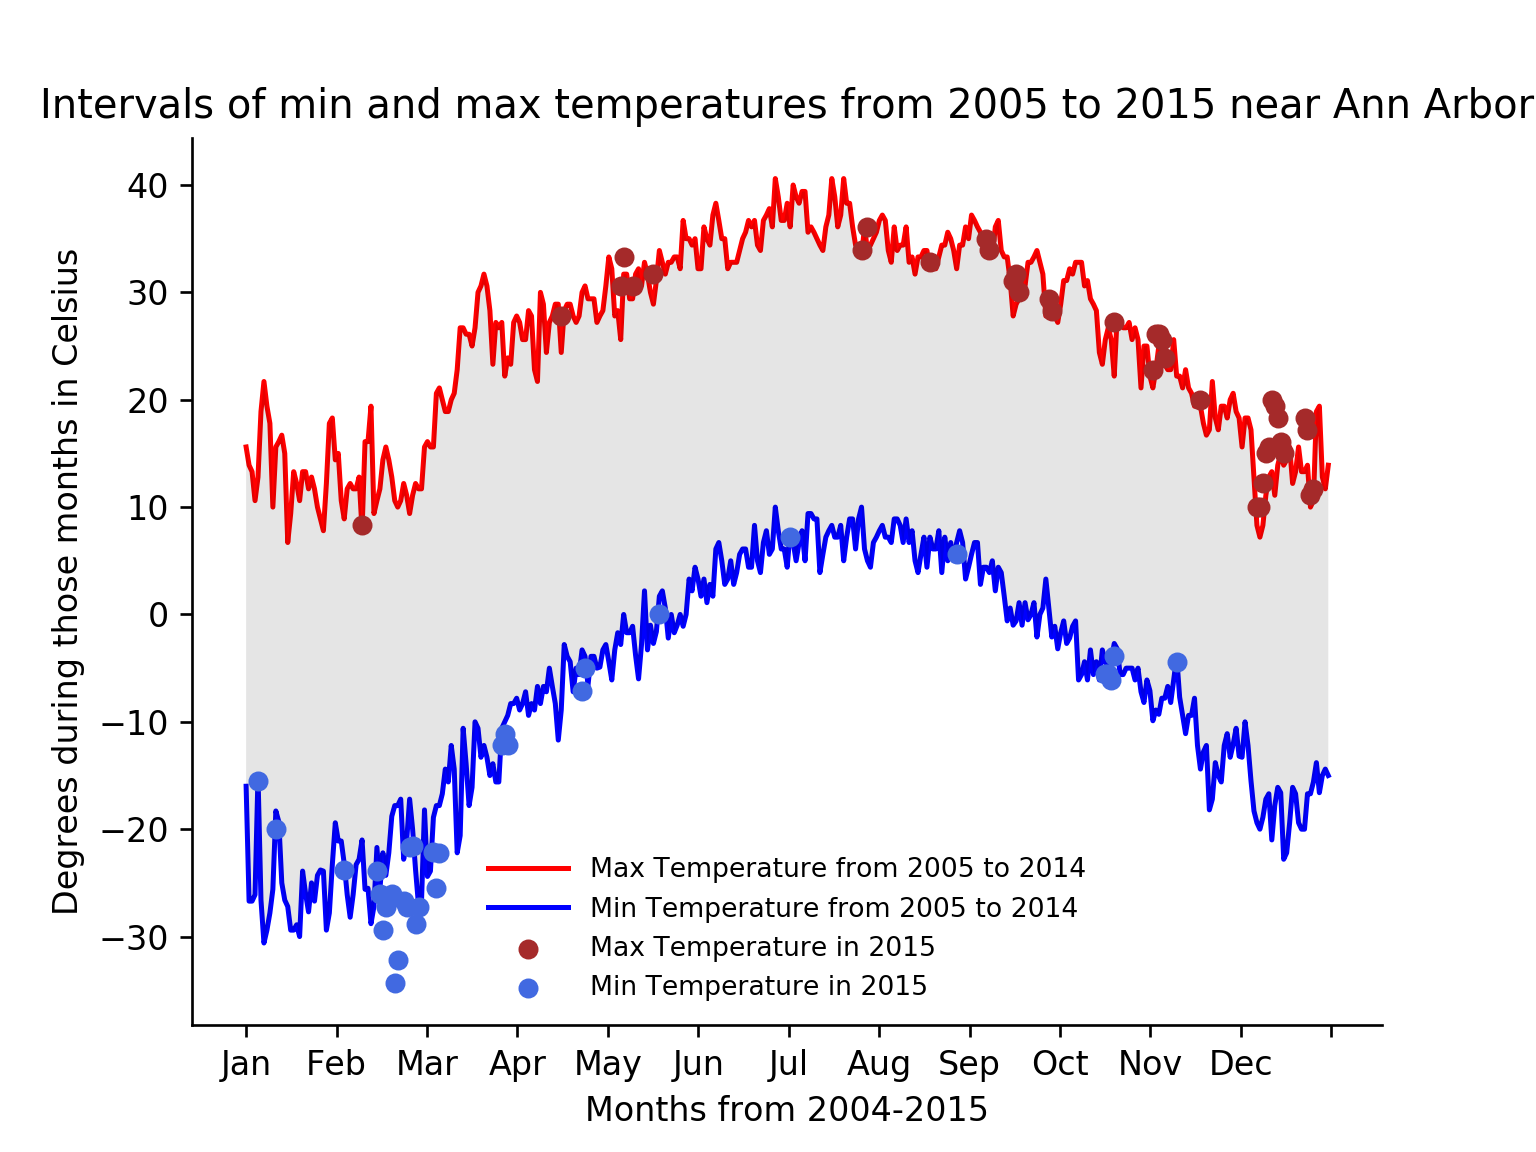

In [19]:

%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

mpl.get_backend()

# Loads stations from Ann Arbor, Michigan
def leaflet_plot_stations(binsize, hashid):
    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))
    station_locations_by_hash = df[df['hash'] == hashid]
    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()
    plt.figure(figsize=(8,8))
    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)
    return mplleaflet.display()

#Reads CSV file, removes leap years, and changes temperature into Celsius
def data():
    df = pd.read_csv("data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv")
    df["MonthandDate"] = df["Date"].apply(lambda x: x[5:])
    df = df[df["MonthandDate"] != "02-29"]
    df["Date"] = df["Date"].apply(lambda x: x[0:4])
    df["Data_Value"] = df["Data_Value"].apply(lambda x: x*.1)
    return df

# Finds max temp per day in all of the years from 2005-2014
def maxTemp():
    highData = data()
    highData = highData[highData["Element"] == "TMAX"]
    highData = highData[highData["Date"] != "2015"]
    tempData = highData.groupby("MonthandDate").agg({"Data_Value":np.max})
    return tempData
# Finds min temp per day in all of the years from 2005-2014
def minTemp():
    minData = data()
    minData = minData[minData["Element"] == "TMIN"]
    minData = minData[minData["Date"] != "2015"]
    tempData = minData.groupby("MonthandDate").agg({"Data_Value":np.min})
    return tempData

# Finds max temp per day in 2015 and compares it to temp from 2005-2014
def high2015Data():
    df = data()
    df = df[df["Date"] == "2015"]
    df = df[df["Element"] == "TMAX"]
    df = df.groupby("MonthandDate").agg({"Data_Value":np.max})
    maxTemp2014 = maxTemp()
    # Merges the temperature where _x is from 2005-2014 and _y is from 2015
    maxVals = pd.merge(maxTemp2014.reset_index(), df.reset_index(), left_index=True, on = 'MonthandDate')
    # Keeps only the values where temp in 2015 is greater
    compareMaxed = maxVals[maxVals['Data_Value_y'] > maxVals['Data_Value_x']]
    return compareMaxed

# Finds min temp per day in 2015 and compares it to temp from 2005-2014
def min2015Data():
    df = data()
    df = df[df["Date"] == "2015"]
    df = df[df["Element"] == "TMIN"]
    df = df.groupby("MonthandDate").agg({"Data_Value":np.min})
    minTemp2014 = minTemp()
    # Merges the temperature where _x is from 2005-2014 and _y is from 2015
    minVals = pd.merge(minTemp2014.reset_index(), df.reset_index(), left_index=True, on = 'MonthandDate')
    # Keeps only the values where temp in 2015 is lower
    compareMins = minVals[minVals['Data_Value_y'] < minVals['Data_Value_x']]
    return compareMins

# Makes the plot
def makePlot():
    # Calls methods
    max2014Temp = maxTemp()
    min2014Temp = minTemp()
    max2015Temp = high2015Data()
    min2015Temp = min2015Data()
    
    # Creates plots of those methods
    plt.figure()
    #plt.subplot(212)
    plt.scatter(max2015Temp.index.tolist(), max2015Temp["Data_Value_y"].values, zorder = 10, c = "brown", label = "Max Temperature in 2015", s = 25)
    plt.scatter(min2015Temp.index.tolist(), min2015Temp["Data_Value_y"].values, c = "royalblue", zorder = 10, label = "Min Temperature in 2015", s = 25)
    plt.plot(max2014Temp.values, c = "red", zorder = 0, label = "Max Temperature from 2005 to 2014")
    plt.plot(min2014Temp.values, c = "blue", zorder = 0, label = "Min Temperature from 2005 to 2014")
    params = {'legend.fontsize': 8,
          'legend.handlelength': 3}
    plt.rcParams.update(params)
    #Legends, Axes, Title, and Labels
    plt.legend()
    plt.title("Intervals of min and max temperatures from 2005 to 2015 near Ann Arbor")
    plt.xlabel("Months from 2004-2015")
    plt.ylabel("Degrees during those months in Celsius")
    x = np.arange(0, 365)
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ticks = np.arange(min(x), max(x)+len(x)/12-1, len(x)/12)
    plt.legend(frameon=False)
    ax = plt.gca()
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.fill_between(range(len(max2014Temp)), 
                       np.array(max2014Temp.values.reshape(len(max2014Temp.values),)), 
                       np.array(min2014Temp.values.reshape(len(max2014Temp.values),)), 
                       facecolor='black', 
                       alpha=0.1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

makePlot()